In [61]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    
        print(os.path.join(dirname))

# Any results you write to the current directory are saved as output.

/kaggle/input
/kaggle/input/dogs-vs-cats
/kaggle/input/dogs-vs-cats/test
/kaggle/input/dogs-vs-cats/test/test
/kaggle/input/dogs-vs-cats/train
/kaggle/input/dogs-vs-cats/train/train


In [62]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [63]:
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import random

# FOR DOG=1 FOR CAT=0

In [64]:
filenames=os.listdir("/kaggle/input/dogs-vs-cats/train/train")
# print(filenames)
category=[]

for i in filenames:
    catg=i.split('.')[0]
#     print(catg)

    if catg=='cat':
        category.append('0') 
        
    else:
        category.append('1')    

In [65]:
category[0:5]

['1', '1', '0', '1', '1']

In [66]:
df=pd.DataFrame({'filename': filenames,
    'category': category})
df.tail()

,filename,category
24995,dog.12002.jpg,1
24996,cat.3538.jpg,0
24997,dog.7276.jpg,1
24998,dog.3530.jpg,1
24999,cat.1117.jpg,0


# Random Photo Generator

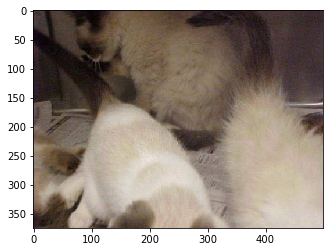

In [67]:
sample = random.choice(filenames)
image = load_img("/kaggle/input/dogs-vs-cats/train/train/"+sample)
plt.imshow(image)

In [68]:
image.size

(499, 375)

# FOR VGG16 Model we need input shape as 224,224
# MODEL

In [69]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16
from keras.models import Model

In [70]:
img_size = [224, 224,3]

In [91]:
vgg = VGG16(input_shape=img_size, weights='imagenet', include_top=False)

for layer in vgg.layers[:15]:
    layer.trainable = False

for layer in vgg.layers[15:]:
    layer.trainable = True
    
last_layer = vgg.get_layer('block5_pool')
last_output = last_layer.output
    

x = GlobalMaxPooling2D()(last_output)

x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

x = layers.Dense(1, activation='sigmoid')(x)

model = Model(vgg.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])


In [72]:
# x = Flatten()(vgg.output)

In [73]:
# prediction = Dense(1, activation='sigmoid')(x)

In [92]:
# model = Model(inputs=vgg.input, outputs=prediction)


model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [75]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [76]:
train_df, test_df = train_test_split(df, test_size=0.1)
train_df = train_df.reset_index()
test_df = test_df.reset_index()


total_train = train_df.shape[0]
total_test = test_df.shape[0]

In [77]:
print(total_train)
print(total_test)

22500
2500


In [78]:
df.dtypes

filename    object
category    object
dtype: object

# TRAIN GENERATOR

In [79]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/kaggle/input/dogs-vs-cats/train/train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(224,224),
    batch_size=32
)


Found 22500 validated image filenames belonging to 2 classes.


# TEST GENERATOR

In [87]:
validation_datagen = ImageDataGenerator(rescale=1./255)
test_generator = validation_datagen.flow_from_dataframe(
    test_df, 
    "/kaggle/input/dogs-vs-cats/train/train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(224,224),
    batch_size=32
)

Found 2500 validated image filenames belonging to 2 classes.


In [81]:
len(train_generator)

704

In [82]:
len(validation_generator)

79

In [93]:
r = model.fit_generator(
  train_generator,
  validation_data=test_generator,
  epochs=5,
  steps_per_epoch=704,
  validation_steps=79
)

Epoch 1/5
704/704 [==============================] - 416s 592ms/step - loss: 0.4161 - accuracy: 0.7924 - val_loss: 0.3043 - val_accuracy: 0.9276
Epoch 2/5
704/704 [==============================] - 388s 552ms/step - loss: 0.2015 - accuracy: 0.9165 - val_loss: 0.1608 - val_accuracy: 0.9476
Epoch 3/5
704/704 [==============================] - 389s 553ms/step - loss: 0.1587 - accuracy: 0.9351 - val_loss: 0.0091 - val_accuracy: 0.9488
Epoch 4/5
704/704 [==============================] - 389s 553ms/step - loss: 0.1397 - accuracy: 0.9427 - val_loss: 0.7490 - val_accuracy: 0.9632
Epoch 5/5
704/704 [==============================] - 391s 555ms/step - loss: 0.1269 - accuracy: 0.9483 - val_loss: 0.1487 - val_accuracy: 0.9632


In [98]:
loss, accuracy = model.evaluate_generator(test_generator, total_test//32)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.963141  ;  loss = 0.057489 


In [106]:
import tensorflow as tf

from keras.models import load_model

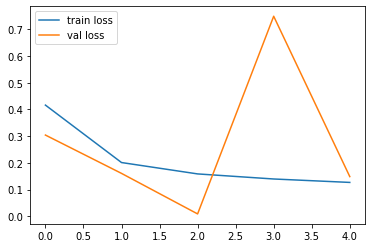

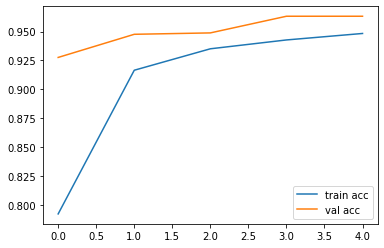

<Figure size 432x288 with 0 Axes>

In [105]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


model.save('model_final.h5')